In [35]:
import numpy as np
import lensmodel as lm
import GPyOpt

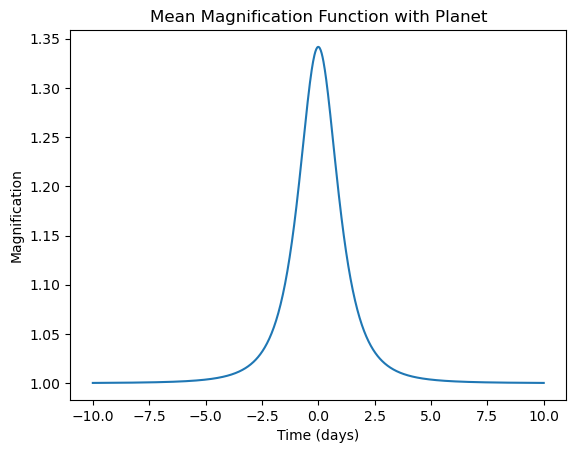

In [36]:
# random initial parameters for mean_function_with_planet
M = 1
d_L = 1
d_S = 2
v_T = 100
M_p = 1
r_P = 1

# random time array
t = np.linspace(-10, 10, 1000)

# plot
import matplotlib.pyplot as plt

plt.plot(t, lm.mean_function_with_planet(t, M, d_L, d_S, v_T, M_p, r_P))
plt.xlabel("Time (days)")
plt.ylabel("Magnification")
plt.title("Mean Magnification Function with Planet")
plt.show()

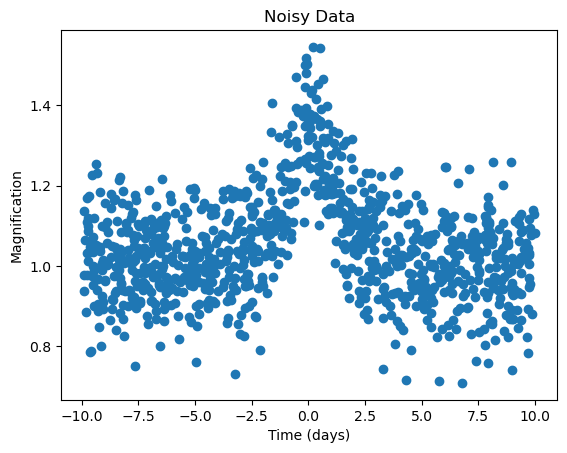

In [37]:
# generate a noisy dataset using noisy_data_calc

# Set random seed for reproducibility
np.random.seed(42)

# Initialize parameters
low = -10
upper = 10
theta = [1, 2, 100, 1]  # Parameters of the lightcurve model: d_L, D_S, v_M_ratio, u_min
noise = 0.1
number = 1000
t_0 = 0

# Generate a noisy dataset using noisy_data_calc
ts, mags = lm.noisy_data_calc(low, upper, theta, noise, number, t_0)

# Plot the noisy data
plt.plot(ts, mags, "o")
plt.xlabel("Time (days)")
plt.ylabel("Magnification")
plt.title("Noisy Data")
plt.show()


**Now proceed to test gaussian process fit to the data with different kernels**

In [38]:
import GPy



In [39]:
x = ts
y = mags
m_full = GPy.models.GPRegression(x[:, None], y[:, None])
_ = m_full.optimize(messages=True, max_f_eval=1000)


In [40]:
xt = np.linspace(0, 100, 400)[:, np.newaxis]
yt_mean, yt_var = m_full.predict(xt)
yt_sd = np.sqrt(yt_var)

In [41]:
import matplotlib.pyplot as plt
import mlai.plot as plot
import mlai

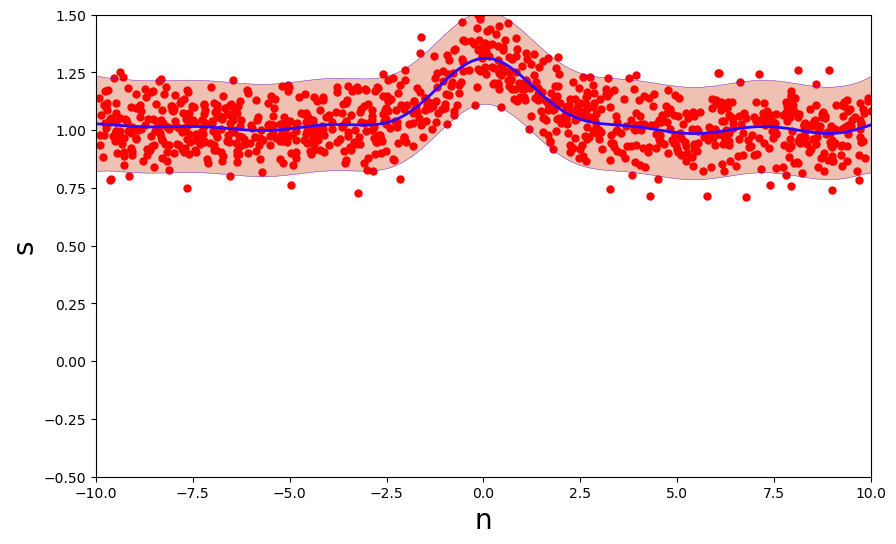

In [42]:
xlim = (-10, 10)
ylim = (-0.5, 1.5)

fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
plot.model_output(m_full, ax=ax, xlabel="n", ylabel="s", fontsize=20, portion=0.2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
mlai.write_figure(
    figure=fig,
    filename="rbf_fit.svg",
    directory="./gp",
    transparent=True,
)

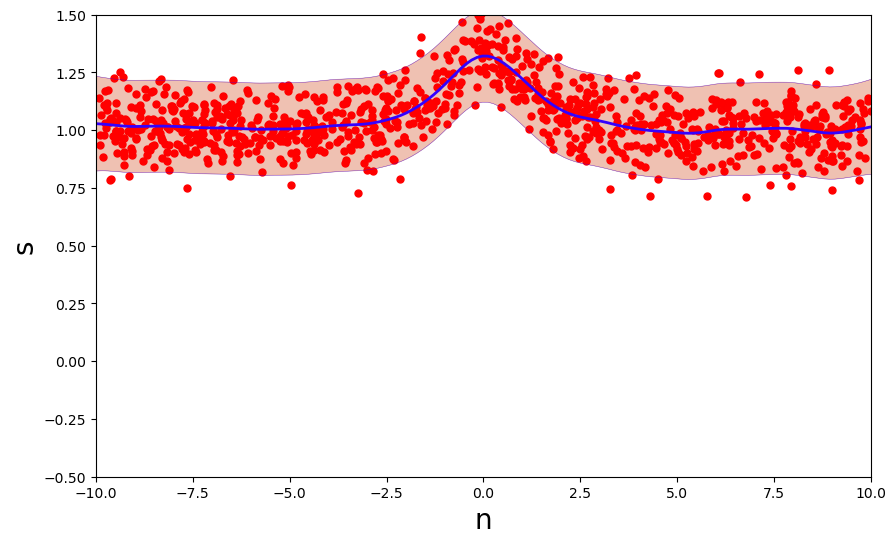

In [43]:
# try a different kernel
k = GPy.kern.Matern32(1)
m_full = GPy.models.GPRegression(x[:, None], y[:, None], kernel=k)
_ = m_full.optimize(messages=True, max_f_eval=1000)

yt_mean, yt_var = m_full.predict(xt)
yt_sd = np.sqrt(yt_var)

fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
plot.model_output(m_full, ax=ax, xlabel="n", ylabel="s", fontsize=20, portion=0.2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
mlai.write_figure(
    figure=fig,
    filename="matern_fit.svg",
    directory="./gp",
    transparent=True,
)

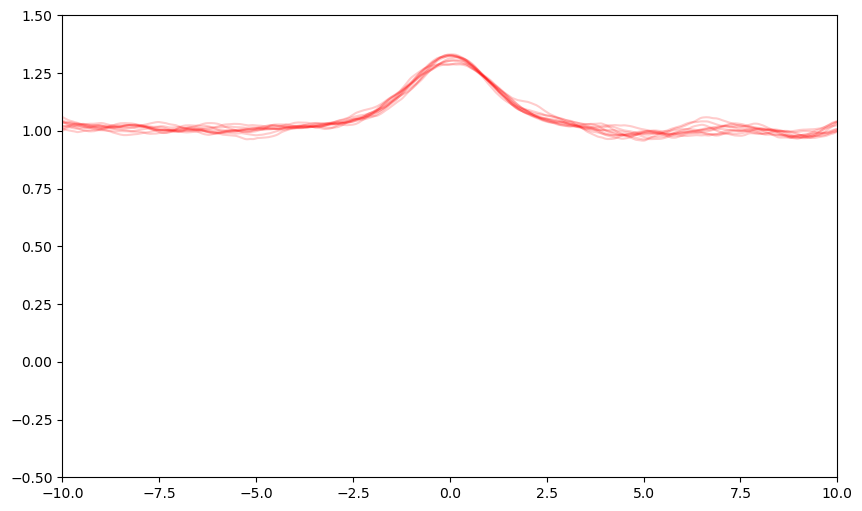

In [44]:
# sample from the posterior
xt = np.linspace(-10, 10, 1000)[:, None]
yt_samples = m_full.posterior_samples_f(xt, full_cov=True, size=10)

fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

for i in range(yt_samples.shape[1]):
    ax.plot(xt, yt_samples[:, i], "r", alpha=0.2)

# ax.plot(x, y, "kx", mew=1.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
mlai.write_figure(
    figure=fig,
    filename="matern_samples.svg",
    directory="./gp",
    transparent=True,
)


**Using Baysesian Optimisation to fit paramters of a model using MSE**

the number of params is: 3


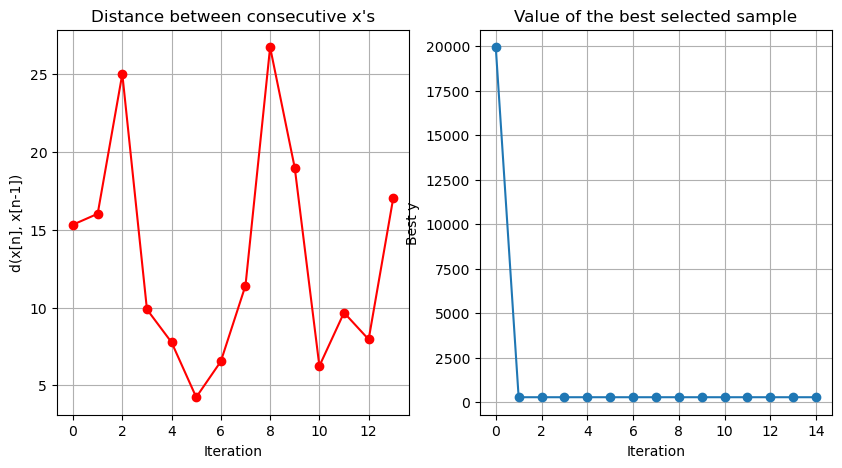

In [45]:
import numpy as np
import GPyOpt
from sklearn.metrics import mean_squared_error as MSE_error

def fit_function_MSE_BO(function, datapoints, bounds, n_iter, y):
    """
    Fit a function using MSE and Bayesian Optimization.

    Args:
    - function: function to fit, e.g., a model (signature: model(x, param1, param2, ...))
    - datapoints: input data points (x values)
    - bounds: parameter bounds for optimization in the form of a list of tuples (lower, upper)
    - n_iter: number of optimization iterations
    - y: observed output values to calculate MSE
    """
    # Define the error function to minimize (MSE error)
    # GPyOpt calls f with a 2D array of shape (1, d). We'll extract theta[0] to get a 1D array.
    def error_function(theta):
        theta = theta[0]  # Extract parameter array from 2D input
        y_pred = function(datapoints, *theta)
        return MSE_error(y, y_pred)  # ensure y_true=y, y_pred=func output

    # Define the domain for each parameter
    domain = [{'name': f'param_{i}', 'type': 'continuous', 'domain': b} for i, b in enumerate(bounds)]
    #print number of parameters
    print('the number of params is:',len(domain))
    # Run Bayesian Optimization
    optimizer = GPyOpt.methods.BayesianOptimization(f=error_function, domain=domain)
    optimizer.run_optimization(max_iter=n_iter)
    optimizer.plot_acquisition()
    return optimizer


# Example usage
if __name__ == "__main__":
    # Example function to fit: a simple quadratic function
    def model(x, a, b, c):
        return a * x**2 + b * x + c

    # Input data points
    x = np.linspace(-5, 5, 100).reshape(-1, 1)
    y = model(x, 2, -3, 5) + np.random.normal(0, 1, size=x.shape)  # observed noisy data

    # Bounds for parameters a, b, c
    bounds = [(-10, 10), (-10, 10), (-10, 10)]  # Lower and upper bounds for a, b, c

    # Fit the function using Bayesian Optimization
    optimizer = fit_function_MSE_BO(model, x, bounds, n_iter=10, y=y)
    optimizer.plot_convergence()



the number of params is: 1


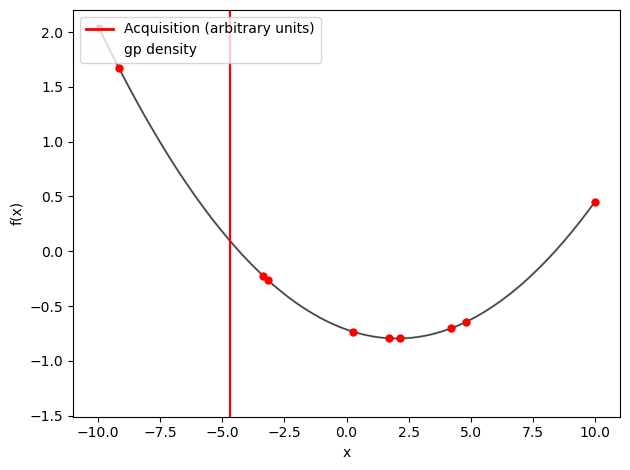

In [49]:
# try another example with function of one parameter
def model(x, a):
    return a * x**2

# Input data points
x = np.linspace(-5, 5, 20).reshape(-1, 1)
y = model(x, 2) + np.random.normal(0, 1, size=x.shape)  # observed noisy data

# Bounds for parameter a
bounds = [(-10, 10)]  # Lower and upper bounds for a

# Fit the function using Bayesian Optimization
optimizer = fit_function_MSE_BO(model, x, bounds, n_iter=5, y=y)



In [ ]:
# note wrking properly? sampling radomly. check gp kernel